In [97]:
from IPython.display import clear_output
!pip install --upgrade pip
!pip install --upgrade pip
!pip install tensorflow==2.4.1
!pip install -U tensorflow-quantum
!pip install cirq
clear_output()

In [98]:
import os
import random
import PIL
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import tensorflow_quantum as tfq
import cirq
import sympy

from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt

In [99]:
from tensorflow.keras.datasets import fashion_mnist as dataset

In [100]:
(X_train, y_train), (X_test, y_test) = dataset.load_data()

In [101]:
def filter_data(x, y):
  """
  Helper Function to filter the dataset
  """
  #filter the data using labels
  keep = (y == 5) | (y == 9)
  x, y = x[keep], y[keep]

  # convert labels to boolean
  # y = True if y==5
  # y = False if y==9
  y = y == 5
  return x,y

In [102]:
#Filter the train set
X_train, y_train = filter_data(X_train, y_train)

#Filter the test_set
X_test, y_test = filter_data(X_test, y_test)

In [103]:
print("The shape of the X_train is {}".format( X_train.shape))
print("The shape of the y_train is {}".format(y_train.shape))
print("The shape of the X_test is {}".format(X_test.shape))
print("The shape of the y_test is {}".format(y_test.shape))

The shape of the X_train is (12000, 28, 28)
The shape of the y_train is (12000,)
The shape of the X_test is (2000, 28, 28)
The shape of the y_test is (2000,)


The First Image has the label False


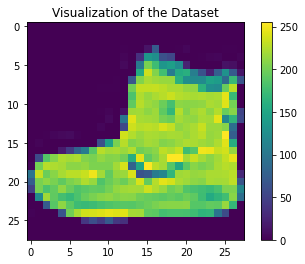

In [104]:
print("The First Image has the label {}".format(y_train[0]))
plt.imshow(X_train[0])
plt.colorbar()
plt.title('Visualization of the Dataset')
plt.show()

In [105]:
X_train = X_train/255.0
X_test = X_test/ 255.0

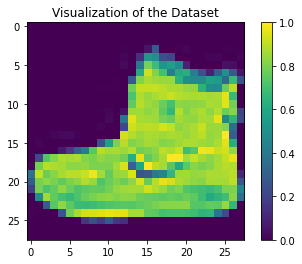

In [106]:
plt.imshow(X_train[0])
plt.colorbar()
plt.title('Visualization of the Dataset')
plt.show()

In [107]:
#Before proceeding, we need to reshape our images in the dataset
X_train = X_train.reshape(X_train.shape[0], *(28,28,1))
X_test = X_test.reshape(X_test.shape[0], *(28,28,1))

In [108]:
X_train = tf.image.resize(X_train, (2,2)).numpy()
X_test = tf.image.resize(X_test, (2,2)).numpy()

In [109]:
#Splitting the training fdataset into train and validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.15, random_state=0)

In [110]:
print("The shape of the X_train is {}".format(X_train.shape))
print("The shape of the y_train is {}".format(y_train.shape))
print("The shape of the X_valid is {}".format(X_valid.shape))
print("The shape of the y_valid is {}".format(y_valid.shape))

The shape of the X_train is (10200, 2, 2, 1)
The shape of the y_train is (10200,)
The shape of the X_valid is (1800, 2, 2, 1)
The shape of the y_valid is (1800,)


In [111]:
X_train = X_train.reshape(X_train.shape[0], *(1,4,1))
X_valid = X_valid.reshape(X_valid.shape[0], *(1,4,1))
X_test = X_test.reshape(X_test.shape[0], *(1,4,1))

In [112]:
print(X_train[0])

[[[0.        ]
  [0.41568628]
  [0.7137255 ]
  [0.73921573]]]


In [113]:
def binary_encode(X,threshold=0.5):
  encoded_images = list()
  for image in X:
    # pixel value is 1 if it's greater than threshold or else zero
    encoded_image = [1 if j>threshold else 0 for j in image[0]]
    encoded_images.append(encoded_image)
  return np.array(encoded_images)

In [114]:
X_train = binary_encode(X_train)

In [115]:
print(X_train[0])

[0 0 1 1]


In [116]:
print("The shape of the X_train is {}".format(X_train.shape))

The shape of the X_train is (10200, 4)


In [117]:
def create_circuit_from_image(encoded_image):
  """
  Returns a circuit for given encoded image

  Parameters:
  encoded_image (array): Encoded Image

  Returns:
  circuit (cirq.Circuit object): cirq circuit
  """
  qubits = cirq.GridQubit.rect(2,2)
  circuit = cirq.Circuit()
  for i, pixel in enumerate(encoded_image):
    if pixel:
      circuit.append(cirq.X(qubits[i]))
  return circuit

In [118]:
X_train = [create_circuit_from_image(encoded_image) for encoded_image in X_train]

In [119]:
print(X_train[0])

(1, 0): ───X───

(1, 1): ───X───


# Step 2: Converting Cirq Circuits to tfq Tensors

In [120]:
X_train_tfq = tfq.convert_to_tensor(X_train)

In [121]:
X_valid = binary_encode(X_valid)
X_test = binary_encode(X_test)

In [122]:
X_valid = [create_circuit_from_image(encoded_image) for encoded_image in X_valid]
X_test = [create_circuit_from_image(encoded_image) for encoded_image in X_test]

In [123]:
X_valid_tfq = tfq.convert_to_tensor(X_valid)
X_test_tfq = tfq.convert_to_tensor(X_test)

# Quantum Neural Network

## Build the QNN

In [124]:
class QNN():
    def __init__(self, data_qubits, readout):
      self.data_qubits = data_qubits
      self.readout = readout

    def add_singleQubit_gate(self,circuit, gate, qubit_index):
      for index in qubit_index:
        circuit.append(gate(self.data_qubits[index]))

    def add_twoQubit_gate(self,circuit, gate, qubit_index):
      if len(qubit_index)!=2:
        raise Exception("The length of the list of indices passed for two qubit \
        gate operations must be equal to two")
      circuit.append(gate(self.data_qubits[qubit_index[0]], self.data_qubits[qubit_index[1]]))

    def add_layer(self, circuit, gate, symbol_gate):
      for i, qubit in enumerate(self.data_qubits):
        symbol = sympy.Symbol(symbol_gate+ '-' + str(i))
        circuit.append(gate(qubit, self.readout)**symbol)

In [125]:
def create_qnn():
    data_qubits = cirq.GridQubit.rect(2,2)
    readout = cirq.GridQubit(-1, -1)
    circuit = cirq.Circuit()

    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    qnn = QNN(
        data_qubits = data_qubits,
        readout=readout)
    
    qnn.add_layer(circuit, cirq.XX, "xx")
    qnn.add_layer(circuit, cirq.ZZ, "zz")

    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [126]:
qmodel, model_readout = create_qnn()

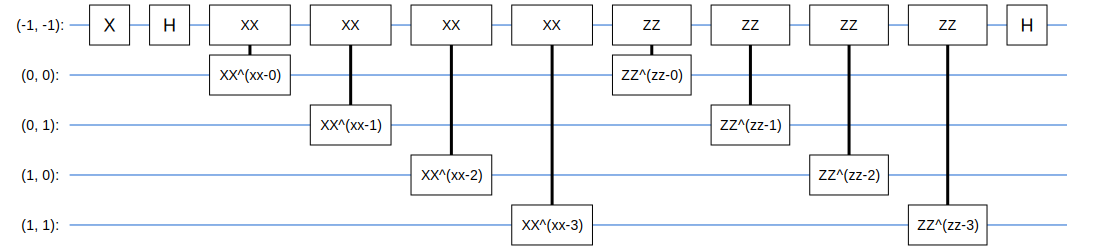

In [127]:
SVGCircuit(qmodel)

In [128]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(qmodel, model_readout),
])

In [129]:
# To use Hinge Loss, we convert the labels to 1 and -1
y_train_h = np.array([1 if i==1 else -1 for i in y_train ])
y_valid_h = np.array([1 if i==1 else -1 for i in y_valid ])
y_test_h = np.array([1 if i==1 else -1 for i in y_test ])

In [130]:
print(y_train_h[0])

1


In [131]:
# Define the custom Hinge Accuracy
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [132]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[hinge_accuracy])

In [133]:
qnn_history = model.fit(
      X_train_tfq, y_train_h,
      batch_size=64,
      epochs=10,
      verbose=1,
      validation_data=(X_valid_tfq, y_valid_h))

Epoch 1/10
160/160 [==============================] - 6s 35ms/step - loss: 0.9254 - hinge_accuracy: 0.5733 - val_loss: 0.6771 - val_hinge_accuracy: 0.6239
Epoch 2/10
160/160 [==============================] - 6s 35ms/step - loss: 0.5643 - hinge_accuracy: 0.7318 - val_loss: 0.4093 - val_hinge_accuracy: 0.8351
Epoch 3/10
160/160 [==============================] - 6s 36ms/step - loss: 0.3962 - hinge_accuracy: 0.8415 - val_loss: 0.3933 - val_hinge_accuracy: 0.8351
Epoch 4/10
160/160 [==============================] - 6s 35ms/step - loss: 0.4022 - hinge_accuracy: 0.8299 - val_loss: 0.3936 - val_hinge_accuracy: 0.7958
Epoch 5/10
160/160 [==============================] - 6s 35ms/step - loss: 0.4150 - hinge_accuracy: 0.7931 - val_loss: 0.3954 - val_hinge_accuracy: 0.7958
Epoch 6/10
160/160 [==============================] - 6s 35ms/step - loss: 0.3905 - hinge_accuracy: 0.8053 - val_loss: 0.3963 - val_hinge_accuracy: 0.7958
Epoch 7/10
160/160 [==============================] - 6s 35ms/step - l

In [134]:
model.evaluate(X_test_tfq, y_test_h)

63/63 [==============================] - 1s 9ms/step - loss: 0.3700 - hinge_accuracy: 0.8229


[0.3699586093425751, 0.8229166865348816]

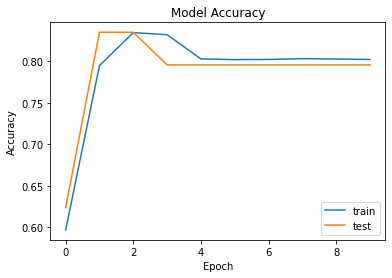

In [135]:
# Visualize Accuracy
plt.plot(qnn_history.history['hinge_accuracy'])
plt.plot(qnn_history.history['val_hinge_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','test'],loc="best")
plt.show()

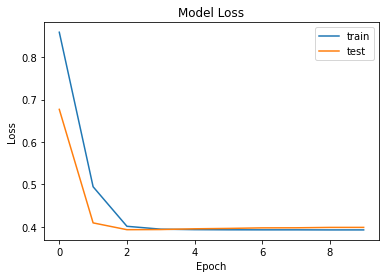

In [136]:
# Visualize Loss
plt.plot(qnn_history.history['loss'])
plt.plot(qnn_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','test'],loc="best")
plt.show()

In [137]:
# Save The Model Weights
model.save_weights('/content/sample_data/QModelWeights')